In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from moles import MolesConfig
from moles import MolesDataset

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images

from moles import MolesConfig
from moles import MolesDataset
from moles import BalancedDataset
from moles import MolesDatasetFast
from moles import ISIC17Dataset
from moles import ISIC17AugDataset

from sklearn.metrics import confusion_matrix, auc, roc_curve, accuracy_score, precision_recall_curve, roc_auc_score, jaccard_score

Using TensorFlow backend.


In [2]:
ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
metrics_file_path = os.path.join(MODEL_DIR, "metrics17")

In [3]:
config = MolesConfig()

In [4]:
dataset_train = ISIC17AugDataset()
dataset_train.load_moles("data/train/")
dataset_train.prepare()
ds = dataset_train

dataset_val = ISIC17Dataset()
dataset_val.load_moles("../Data/val")
dataset_val.prepare()

dataset_train_or = ISIC17Dataset()
dataset_train_or.load_moles("../Data/train")
dataset_train_or.prepare()

dataset_val_r = ISIC17AugDataset()
dataset_val_r.load_moles("data/val_resized/")
dataset_val_r.prepare()
ds = dataset_train

dataset_test = ISIC17AugDataset()
dataset_test.load_moles("data/test/")
dataset_test.prepare()

600

In [9]:
class InferenceConfig(MolesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

def get_metrics(y,y_pred):

    if type(y) == type([]):
        y = np.array(y)

    if type(y_pred) == type([]):
        y_pred = np.array(y_pred)
        
    #tp, fp, fn, tn = confusion_matrix(y,y_pred).ravel()
    metrics = {}
    metrics["acc"] = (((y_pred) == y).sum()/len(y)) #Accuracy
    try:
        metrics["auc"] = roc_auc_score(y,y_pred) # AUC
    except ValueError:
        metrics["auc"] = 0
    #metrics["sensitivity"] = (tp/(tp+fn))#sensitivity
    #metrics["specificity"] = (tn/(tn+fp))#specificity
    #metrics.append(tp/(tp+fn))#tpr
    #metrics.append(fp/(fp+tn))#fpr

    return metrics

def eval_model(model, dataset):
    image_ids = dataset.image_ids

    APs = []
    Ps = []
    Rs = []
    preds = []
    gts = []
    ious = [] 

    for image_id in tqdm(image_ids):
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                image_id, use_mini_mask=False)

        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
    
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, [gt_class_id], gt_mask,
                            r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        APs.append(AP)
        Ps.append(precisions)
        Rs.append(recalls)
        gts.append(gt_class_id[0])
        if len(r["scores"]) != 0:
            preds.append(r["class_ids"][r["scores"].argmax()])
            pred_mask = r["masks"][:,:,r["scores"].argmax()]
            js = jaccard_score(gt_mask.flatten(), pred_mask.flatten())
            ious.append(js)
        else:
            preds.append(-1)
            ious.append(0)
    
    return APs, ious, preds, gts 

In [6]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [7]:
model_path = "logs/moles20200724T1454/mask_rcnn_moles_0164.h5"
model.load_weights(model_path, by_name=True)

Re-starting from epoch 164


In [59]:
# Validation Set
(APs, IoUs, preds_v, gts_v) = eval_model(model, dataset_val_r)
df_v = pd.DataFrame({"gts": gts_v, "preds": preds_v})

100%|██████████| 400/400 [00:39<00:00, 10.02it/s]


In [10]:
# Triaining Set
(APs, IoUs, preds_t, gts_t) = eval_model(model, dataset_train)
df_t = pd.DataFrame({"gts": gts_t, "preds": preds_t})

100%|██████████| 5710/5710 [09:57<00:00,  9.56it/s]


In [14]:
# Test Set
(APs, IoUs, preds_tst, gts_tst) = eval_model(model, dataset_test)
df_tst = pd.DataFrame({"gts": gts_tst, "preds": preds_tst})

100%|██████████| 600/600 [08:15<00:00,  1.21it/s]


In [12]:
def print_counts(df):
    print(df["gts"].value_counts())
    print(df["preds"].value_counts())

def print_wrong(df):
    df_wrong = df[df["gts"] != df["preds"]]
    print(df_wrong["gts"].value_counts())
    print(df_wrong["preds"].value_counts())
    print(len(df[df["gts"] != df["preds"]]))


In [15]:
print_counts(df_tst)

print_wrong(df_tst)

1    393
2    117
3     90
Name: gts, dtype: int64
 1    446
 3     90
 2     61
-1      3
Name: preds, dtype: int64
2    77
1    43
3    42
Name: gts, dtype: int64
 1    96
 3    42
 2    21
-1     3
Name: preds, dtype: int64
162


In [16]:
np.mean(IoUs)

0.7427317104840877

In [51]:
image_id = 30
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config,
                        image_id, use_mini_mask=False)

# Run object detection
results = model.detect([image], verbose=0)
r = results[0]
# Compute AP

AP, precisions, recalls, overlaps =\
    utils.compute_ap(gt_bbox, [gt_class_id], gt_mask,
                    r["rois"], r["class_ids"], r["scores"], r['masks'])

pred_mask = r["masks"][:,:,r["scores"].argmax()]
js = jaccard_score(gt_mask.flatten(), pred_mask.flatten())

In [50]:
r['masks'].shape

(256, 256, 2)

In [52]:
js

0.8814721522530087

In [17]:
import importlib

In [15]:
len(df[df["gts"] != df["preds"]])

NameError: name 'df' is not defined

In [27]:
df[df["gts"] != df["preds"]]

,gts,preds
0,2,-1
5,2,1
8,1,-1
11,1,-1
12,1,3
...,...,...
5700,2,-1
5703,2,-1
5704,1,-1
5705,1,-1


In [35]:
dataset = dataset_train
image_id = 5706
(dataset.image_info[image_id]['path'])

'data/train/images/ISIC_0001242.jpg'

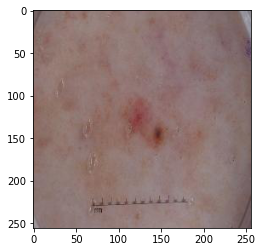

In [36]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)
molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)

plt.imshow(image)

In [37]:
# Run through model
results = model.detect([image], verbose=1)

# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  193.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -108.80000  max:   73.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 4, 4)       min:   -2.30817  max:    4.19882  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.09216  max:    0.91037  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    0.00000  float32


In [38]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

15 Valid proposals out of 1000
3 Positive ROIs
[('BG', 997), ('melanoma', 1), ('seborrheic_keratosis', 2)]


roi_bbox_specific        shape: (1000, 4)             min:   -1.39967  max:    3.55022  float32
refined_proposals        shape: (1000, 4)             min:  -19.00000  max:  241.00000  int32


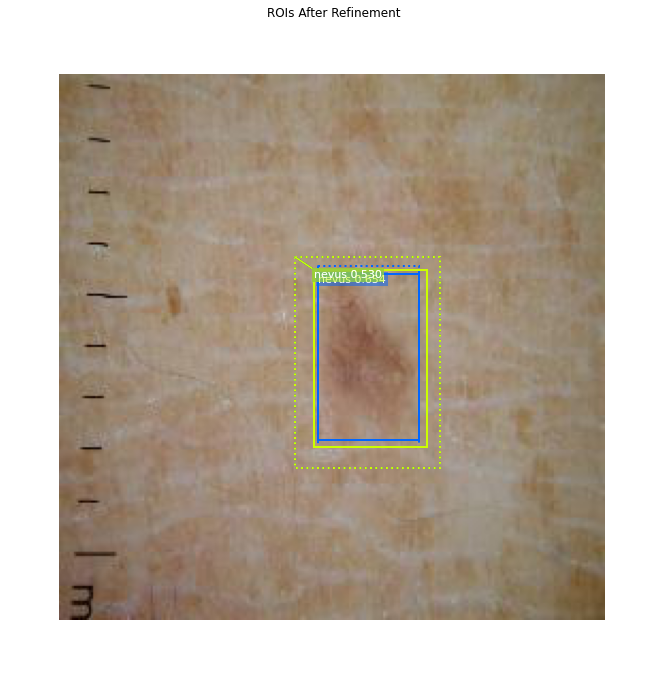

In [26]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement")

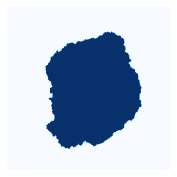

In [165]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00001  max:    1.00000  float32
1 detections: ['melanoma']
det_mask_specific        shape: (1, 28, 28)           min:    0.00039  max:    1.00000  float32
det_masks                shape: (1, 256, 256)         min:    0.00000  max:    1.00000  bool


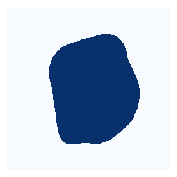

In [166]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [167]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 256, 256, 3)      min:  -98.80000  max:  106.30000  float32
res4w_out                shape: (1, 16, 16, 1024)     min:    0.00000  max:   51.85868  float32
rpn_bbox                 shape: (1, 16368, 4)         min:   -6.97877  max:  107.17657  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


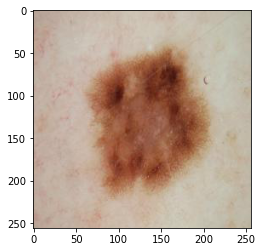

In [168]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

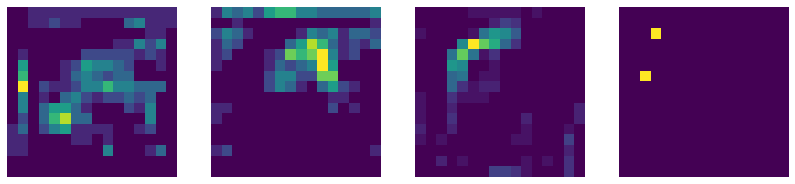

In [169]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))